MCDAA, UdelaR
# Computer Vision 2025 -  Proyecto Final - Entrenamiento del Modelo Resnet
Pablo Molina
Joana Auriello

# ResNet50 WITHOUT augmentation
- Use of checkpoints for training in different sessions
- Specific directory to save checkpoints and model for ResNet50 WITHOUT augmentation, so we don't step over other running models

#How to continue training if the Colab session ends

This project saves its progress in checkpoints inside Google Drive.
Because of that, you can stop and resume training at any time.

Below are the exact steps depending on whether training stopped during Phase 1 or Phase 2.

##General Steps (Always do these after re-opening Colab)

Every time you start a new session:
1. Mount Google Drive

```
from google.colab import drive
drive.mount('/content/drive')
```
2. Set the same experiment name

`EXP_NAME = "resnet50_noaug"

3. Run all setup cells up to (but not including) training

This means:
- imports
- load the CSV
- load train/val splits
- create data generators
- create checkpoint/log folders
- build-or-load-model section

During setup, the code will automatically check whether a checkpoint already exists and will load it.

### If the session ended during Phase 1 (head training)

Phase 1 checkpoints are saved in (at least one epoch needs to have finished in order o have a checkpoint saved to continue training):

`experiments/<EXP_NAME>/checkpoints/<EXP_NAME>_phase1_best.keras`

How to resume:

After you run the setup cells, the model-loading logic will do:

`if os.path.exists(phase1_ckpt_path):
    model = tf.keras.models.load_model(phase1_ckpt_path)`

4. All we need to do is run the Phase 1 training cell again:
`history1 = model.fit(...)`
- Training will continue from the saved best checkpoint.
- We can run this multiple times, in multiple sessions.

### If the session ended during Phase 2 (fine-tuning)

Phase 2 checkpoints are saved in:

`experiments/<EXP_NAME>/checkpoints/<EXP_NAME>_phase2_best.keras`

How to resume:

After running the setup cells, Phase 2 loading logic will do:

`if os.path.exists(phase2_ckpt_path):
    model = tf.keras.models.load_model(phase2_ckpt_path)
else:
    model = tf.keras.models.load_model(phase1_ckpt_path)`


This ensures:

- If Phase 2 had already started → we resume fine-tuning

- If Phase 2 had not started yet → it loads the Phase 1 best model instead

We just need to 4. Run the Phase 2 training cell: `history2 = model.fit(...)` and Fine-tuning continues from where it stopped.

Summary
| Situation                               | What to do                                                                                                                    |
| --------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| Session ended during Phase 1            | Mount Drive → Set EXP_NAME → Run setup → Run Phase 1 training cell again                                                      |
| Session ended during Phase 2            | Mount Drive → Set EXP_NAME → Run setup → Run Phase 2 training cell again                                                      |
| You’re not sure which phase you were in | Run setup → Code automatically loads Phase 2 checkpoint if it exists, else Phase 1 → Train Phase 2 if you intend to fine-tune |




### Base setup
1. We set up the directories and also the directory for the logs, so that if we train more than one model at the same time they do not step into one and other

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import tensorflow as tf

# Your working directory
#pablo if you run this change the work dir
WORK_DIR = '/content/drive/MyDrive/Colab Notebooks/ComputerVision'

# Name of this experiment
EXP_NAME = 'resnet50_noaug_v2'  # <-- new name so this is a clean run

# Base directory for this experiment
EXP_DIR = os.path.join(WORK_DIR, 'experiments', EXP_NAME)
os.makedirs(EXP_DIR, exist_ok=True)

# Path to the CSV with original images and labels (shared across experiments)
CSV_PATH = os.path.join(WORK_DIR, 'image_labels.csv')

print("WORK_DIR:", WORK_DIR)
print("CSV_PATH:", CSV_PATH)
print("EXP_NAME:", EXP_NAME)
print("EXP_DIR :", EXP_DIR)


Mounted at /content/drive
WORK_DIR: /content/drive/MyDrive/Colab Notebooks/ComputerVision
CSV_PATH: /content/drive/MyDrive/Colab Notebooks/ComputerVision/image_labels.csv
EXP_NAME: resnet50_noaug_v2
EXP_DIR : /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2


Step 1.1 - SPEEDUP: Copy raw dataset to local disk & rewrite CSV paths

In [2]:
# ==========================================================
# Step 1.1 – SPEEDUP: Copy raw dataset to local disk & rewrite CSV paths
# ==========================================================
LOCAL_RAW_DATA_DIR = "/content/Dataset_Consolidado_LOCAL"

# UPDATE THIS TO MATCH YOUR ZIP FILE NAME EXACTLY
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/Dataset Consolidado.zip"

# 1) Unzip dataset to /content (local VM storage) if not already there
if not os.path.exists(LOCAL_RAW_DATA_DIR):
    print("Unzipping dataset to local VM storage...")
    !unzip -q "$ZIP_PATH" -d /content/
    # After unzip, folder name is likely "Dataset Consolidado"
    !mv "/content/Dataset Consolidado" "$LOCAL_RAW_DATA_DIR"
    print("Unzip complete.")
else:
    print("Local dataset already exists — fast mode enabled.")

# 2) Load CSV and rewrite 'image_path' from Drive to local paths
df_all = pd.read_csv(CSV_PATH)
print("Total images (from CSV):", len(df_all))

# Original raw data directory on Drive
RAW_DATA_DIR = os.path.join(WORK_DIR, 'Dataset Consolidado')

def convert_drive_to_local(path):
    """
    Convert a path that points to Drive-based dataset
    into the equivalent path inside LOCAL_RAW_DATA_DIR (/content/...).
    """
    return path.replace(RAW_DATA_DIR, LOCAL_RAW_DATA_DIR)

df_all['image_path'] = df_all['image_path'].apply(convert_drive_to_local)

print("Example converted path:")
print(df_all.iloc[0]['image_path'])
df_all.head()

Unzipping dataset to local VM storage...
Unzip complete.
Total images (from CSV): 59001
Example converted path:
/content/Dataset_Consolidado_LOCAL/Papel y Carton/paper_2091.jpg


,image_path,label
0,/content/Dataset_Consolidado_LOCAL/Papel y Car...,Papel y Carton
1,/content/Dataset_Consolidado_LOCAL/Papel y Car...,Papel y Carton
2,/content/Dataset_Consolidado_LOCAL/Papel y Car...,Papel y Carton
3,/content/Dataset_Consolidado_LOCAL/Papel y Car...,Papel y Carton
4,/content/Dataset_Consolidado_LOCAL/Papel y Car...,Papel y Carton


### STEP 2. Train/Val/TST split files / set experiment-specific names
So different experiments can keep different splits if you ever change SEED or VAL_SPLIT.

In [3]:
# Load the full list of images and labels
df_all = pd.read_csv(CSV_PATH)
print("Total images:", len(df_all))
df_all.head()

SEED = 42

# Fractions for three-way split
TRAIN_FRAC = 0.8
VAL_FRAC   = 0.1
TEST_FRAC  = 0.1

rng = np.random.default_rng(SEED)

train_idx = []
val_idx   = []
test_idx  = []

# Stratified split per label
for label, group in df_all.groupby('label', sort=False):
    idx = group.index.to_numpy()
    rng.shuffle(idx)
    n_total = len(idx)

    n_train = int(n_total * TRAIN_FRAC)
    n_val   = int(n_total * VAL_FRAC)
    n_test  = n_total - n_train - n_val  # remaining

    train_idx.extend(idx[:n_train])
    val_idx.extend(idx[n_train:n_train + n_val])
    test_idx.extend(idx[n_train + n_val:])

df_train_orig = df_all.loc[train_idx].reset_index(drop=True)
df_val_orig   = df_all.loc[val_idx].reset_index(drop=True)
df_test_orig  = df_all.loc[test_idx].reset_index(drop=True)

print("Train originals:", len(df_train_orig))
print("Val originals   :", len(df_val_orig))
print("Test originals  :", len(df_test_orig))

# Save split for this specific experiment
split_train_path = os.path.join(EXP_DIR, f'train_{EXP_NAME}.csv')
split_val_path   = os.path.join(EXP_DIR, f'val_{EXP_NAME}.csv')
split_test_path  = os.path.join(EXP_DIR, f'test_{EXP_NAME}.csv')

df_train_orig.to_csv(split_train_path, index=False)
df_val_orig.to_csv(split_val_path, index=False)
df_test_orig.to_csv(split_test_path, index=False)

print("Train split saved to:", split_train_path)
print("Val split saved to  :", split_val_path)
print("Test split saved to :", split_test_path)


Total images: 59001
Train originals: 47195
Val originals   : 5896
Test originals  : 5910
Train split saved to: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/train_resnet50_noaug_v2.csv
Val split saved to  : /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/val_resnet50_noaug_v2.csv
Test split saved to : /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/test_resnet50_noaug_v2.csv


### STEP 3: Generators (no aug) and truncated image handling

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

# Allow loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True
print("ImageFile.LOAD_TRUNCATED_IMAGES =", ImageFile.LOAD_TRUNCATED_IMAGES)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# NO augmentation, only rescale
train_datagen   = ImageDataGenerator(rescale=1./255)
valtest_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    df_train_orig,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_gen = valtest_datagen.flow_from_dataframe(
    df_val_orig,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = valtest_datagen.flow_from_dataframe(
    df_test_orig,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False
)


ImageFile.LOAD_TRUNCATED_IMAGES = True
Found 47195 validated image filenames belonging to 12 classes.
Found 5896 validated image filenames belonging to 12 classes.
Found 5910 validated image filenames belonging to 12 classes.


### Step 4. Class weights

In [5]:
class_indices = train_gen.class_indices
print("class_indices:", class_indices)

index_to_class = {v: k for k, v in class_indices.items()}
num_classes = len(class_indices)
print("num_classes:", num_classes)

class_counts = np.bincount(train_gen.classes, minlength=num_classes)
total = class_counts.sum()

class_weight = {
    cls_idx: total / (num_classes * count)
    for cls_idx, count in enumerate(class_counts) if count > 0
}

print("Class counts:", class_counts)
print("Class weights:", class_weight)


class_indices: {'Bio organico': 0, 'Envase Plasticos': 1, 'Papel y Carton': 2, 'Reciclables Varios Cigarro': 3, 'Reciclables Varios Electronicos': 4, 'Reciclables Varios Madera': 5, 'Reciclables Varios Metal': 6, 'Reciclables Varios Otros': 7, 'Reciclables Varios Plastico': 8, 'Reciclables Varios Textiles': 9, 'Reciclables Varios Vidrio': 10, 'Todo lo demás': 11}
num_classes: 12
Class counts: [ 6140  3192  7432   128  2655   665  2466   716  2485 13786  5642  1888]
Class weights: {0: np.float64(0.6405401737242128), 1: np.float64(1.2321167502088555), 2: np.float64(0.5291868496591317), 3: np.float64(30.725911458333332), 4: np.float64(1.481324544883867), 5: np.float64(5.914160401002507), 6: np.float64(1.5948567180319004), 7: np.float64(5.492900372439479), 8: np.float64(1.5826626425217976), 9: np.float64(0.28528337927365927), 10: np.float64(0.6970784591752334), 11: np.float64(2.0831126412429377)}


### sTEP 5. Callbacks, checkpoints, logs. Experiment-specific RESNET50 NO AUGMENTATION checkpoints & logs
Everything now lives under:

<WORK_DIR>/experiments/<EXP_NAME>/...

So experiments don’t overwrite one another.

In [6]:
# Base directory for checkpoints & logs is EXP_DIR
ckpt_dir = os.path.join(EXP_DIR, 'checkpoints')
log_dir  = os.path.join(EXP_DIR, 'logs')

os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

phase1_ckpt_path = os.path.join(ckpt_dir, f'{EXP_NAME}_phase1_best.keras')
phase2_ckpt_path = os.path.join(ckpt_dir, f'{EXP_NAME}_phase2_best.keras')

print("Checkpoint dir:", ckpt_dir)
print("Log dir:", log_dir)
print("Phase 1 ckpt:", phase1_ckpt_path)
print("Phase 2 ckpt:", phase2_ckpt_path)

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)


Checkpoint dir: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints
Log dir: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/logs
Phase 1 ckpt: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase1_best.keras
Phase 2 ckpt: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase2_best.keras


### sTEP 6.  Model build / load (names stay unique via EXP_NAME checkpoints)

In [7]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def build_resnet50_model(num_classes):
    base = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base.trainable = False   # Phase 1: backbone frozen

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    # Ensure a consistent backbone name
    model.layers[1]._name = 'resnet50'
    return model

if os.path.exists(phase1_ckpt_path):
    print("Loading existing Phase 1 model from checkpoint...")
    model = tf.keras.models.load_model(phase1_ckpt_path)
else:
    print("Building new Phase 1 model...")
    model = build_resnet50_model(num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Loading existing Phase 1 model from checkpoint...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        24,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### sTEP 7.  Phase 1 training (head only) WITH shorter, continuous epochs

In [8]:
# ------------------------------------------
# Phase 1 – Train classifier head (NO augmentation) with continuous, shorter epochs
# ------------------------------------------

# FINAL number of Phase-1 epochs we want TOTAL.
TOTAL_EPOCHS_PHASE1 = 5   # <-- set this once for this experiment

# !!! Update this BEFORE EACH RUN, based on how many Phase 1 epochs
#    have already finished successfully.
#
# Examples:
#   - First ever run        → ALREADY_DONE_PHASE1 = 0
#   - If 3 epochs finished  → ALREADY_DONE_PHASE1 = 3
#   - If all 5 are finished → ALREADY_DONE_PHASE1 = 5
ALREADY_DONE_PHASE1 = 4   # <-- UPDATE THIS BEFORE RUNNING

EPOCHS_REMAINING_PHASE1 = TOTAL_EPOCHS_PHASE1 - ALREADY_DONE_PHASE1

# Shorter epochs for Phase 1 (full would be ~1400+ steps)
PHASE1_STEPS_PER_EPOCH = 800
VALIDATION_STEPS_1 = None  # use all validation batches

if EPOCHS_REMAINING_PHASE1 <= 0:
    print(f"[Phase 1 NO-AUG] Already completed {ALREADY_DONE_PHASE1} epochs.")
    print(f"[Phase 1 NO-AUG] TOTAL_EPOCHS_PHASE1 = {TOTAL_EPOCHS_PHASE1}, nothing more to train.")
else:
    print(f"[Phase 1 NO-AUG] Target total epochs: {TOTAL_EPOCHS_PHASE1}")
    print(f"[Phase 1 NO-AUG] Already completed : {ALREADY_DONE_PHASE1}")
    print(f"[Phase 1 NO-AUG] This run will train {EPOCHS_REMAINING_PHASE1} more epochs "
          f"(from epoch {ALREADY_DONE_PHASE1} to {TOTAL_EPOCHS_PHASE1 - 1})")
    print(f"[Phase 1 NO-AUG] Steps per epoch   : {PHASE1_STEPS_PER_EPOCH}")

    phase1_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=phase1_ckpt_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    history1 = model.fit(
        train_gen,
        validation_data=val_gen,
        initial_epoch=ALREADY_DONE_PHASE1,   # resume from here
        epochs=TOTAL_EPOCHS_PHASE1,          # stop at this total
        steps_per_epoch=PHASE1_STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS_1,
        callbacks=[phase1_checkpoint_cb, early_stop_cb, reduce_lr_cb, tensorboard_cb],
        class_weight=class_weight,
        verbose=1
    )


[Phase 1 NO-AUG] Target total epochs: 5
[Phase 1 NO-AUG] Already completed : 4
[Phase 1 NO-AUG] This run will train 1 more epochs (from epoch 4 to 4)
[Phase 1 NO-AUG] Steps per epoch   : 800


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.1989 - loss: 2.2388 
Epoch 5: val_accuracy improved from -inf to 0.24474, saving model to /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase1_best.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 24775s 31s/step - accuracy: 0.1989 - loss: 2.2388 - val_accuracy: 0.2447 - val_loss: 2.2300 - learning_rate: 0.0010


### Step 8. Phase 2: fine-tune top of backbone

For Phase 2 (fine-tuning) we now:

- Resume from a checkpoint: load Phase 2 best if it exists, otherwise Phase 1 best.

- Use shorter epochs: steps_per_epoch = 400 so each epoch finishes faster and checkpoints are written more frequently.

- Keep a small number of fine-tuning epochs (e.g. EPOCHS_PHASE2_PER_RUN = 8), which corresponds to roughly 1–2 effective passes over the data at a low learning rate.

- This improves robustness on Collab (less risk of losing a long epoch) without reducing model quality.

In [9]:
# ------------------------------------------
# Phase 2 – Fine-Tune the Top Layers (NON-AUG ResNet50)
# ------------------------------------------

# Prefer resuming from best Phase 2 model if it exists, else start from Phase 1 best
if os.path.exists(phase2_ckpt_path):
    print(f"Loading best Phase 2 model for experiment: {EXP_NAME}")
    print("  from:", phase2_ckpt_path)
    model = tf.keras.models.load_model(phase2_ckpt_path)
elif os.path.exists(phase1_ckpt_path):
    print(f"Loading best Phase 1 model for experiment: {EXP_NAME}")
    print("  from:", phase1_ckpt_path)
    model = tf.keras.models.load_model(phase1_ckpt_path)
else:
    raise FileNotFoundError(
        f"Phase 1 or Phase 2 checkpoint not found for experiment '{EXP_NAME}'. "
        "Train Phase 1 first."
    )

# Get the backbone by name
base = model.get_layer('resnet50')
print("Backbone name:", base.name)
print("Total backbone layers:", len(base.layers))

# Unfreeze top ~30% of layers
fine_tune_at = int(len(base.layers) * 0.7)
for i, layer in enumerate(base.layers):
    layer.trainable = (i >= fine_tune_at)

print(
    "Trainable backbone layers in Phase 2:",
    sum(layer.trainable for layer in base.layers)
)

# Recompile with smaller LR for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Loading best Phase 1 model for experiment: resnet50_noaug_v2
  from: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase1_best.keras
Backbone name: resnet50
Total backbone layers: 175
Trainable backbone layers in Phase 2: 53


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        24,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 17,238,028 (65.76 MB)

 Non-trainable params: 6,374,272 (24.32 MB)

### Step 9. Phase 2 training (shorter, continuous epochs)

In [10]:
# ------------------------------------------
# Phase 2 – Fine-tune backbone (NO augmentation) with continuous epochs
# ------------------------------------------

phase2_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=phase2_ckpt_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# FINAL number of Phase-2 epochs we want TOTAL.
TOTAL_EPOCHS_PHASE2 = 20   # <-- set this once for this experiment

# !!! Update this BEFORE EACH RUN, based on how many Phase 2 epochs
#    have already finished successfully.
#
# Examples:
#   - First ever fine-tuning run  → ALREADY_DONE_PHASE2 = 0
#   - If 3 fine-tuning epochs ran → ALREADY_DONE_PHASE2 = 3
ALREADY_DONE_PHASE2 = 20   # <-- UPDATE THIS BEFORE RUNNING

EPOCHS_REMAINING_PHASE2 = TOTAL_EPOCHS_PHASE2 - ALREADY_DONE_PHASE2

PHASE2_STEPS_PER_EPOCH = 400     # shorter epochs (full would be ~1400+ steps)
VALIDATION_STEPS_2 = None        # use all validation batches; or set e.g. 200

if EPOCHS_REMAINING_PHASE2 <= 0:
    print(f"[Phase 2 NO-AUG] Already completed {ALREADY_DONE_PHASE2} epochs.")
    print(f"[Phase 2 NO-AUG] TOTAL_EPOCHS_PHASE2 = {TOTAL_EPOCHS_PHASE2}, nothing more to train.")
else:
    print(f"[Phase 2 NO-AUG] Target total epochs: {TOTAL_EPOCHS_PHASE2}")
    print(f"[Phase 2 NO-AUG] Already completed : {ALREADY_DONE_PHASE2}")
    print(f"[Phase 2 NO-AUG] This run will train {EPOCHS_REMAINING_PHASE2} more epochs "
          f"(from epoch {ALREADY_DONE_PHASE2} to {TOTAL_EPOCHS_PHASE2 - 1})")
    print(f"Steps per epoch: {PHASE2_STEPS_PER_EPOCH}")

    history2 = model.fit(
        train_gen,
        validation_data=val_gen,
        initial_epoch=ALREADY_DONE_PHASE2,   # resume here
        epochs=TOTAL_EPOCHS_PHASE2,          # stop at this total
        steps_per_epoch=PHASE2_STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS_2,
        callbacks=[phase2_checkpoint_cb, early_stop_cb, reduce_lr_cb, tensorboard_cb],
        class_weight=class_weight,
        verbose=1
    )


[Phase 2 NO-AUG] Target total epochs: 20
[Phase 2 NO-AUG] Already completed : 0
[Phase 2 NO-AUG] This run will train 20 more epochs (from epoch 0 to 19)
Steps per epoch: 400
Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1653 - loss: 10.0674 
Epoch 1: val_accuracy improved from -inf to 0.21336, saving model to /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase2_best.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 4950s 12s/step - accuracy: 0.1653 - loss: 10.0560 - val_accuracy: 0.2134 - val_loss: 2.1964 - learning_rate: 1.0000e-05
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2173 - loss: 2.2697
Epoch 2: val_accuracy improved from 0.21336 to 0.28867, saving model to /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase2_best.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 3492s 9s/step - accuracy: 0.2173 - loss: 2.2697 - val_accuracy: 0.2887

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy improved from 0.31716 to 0.36601, saving model to /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase2_best.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 1241s 3s/step - accuracy: 0.3070 - loss: 2.0113 - val_accuracy: 0.3660 - val_loss: 1.9030 - learning_rate: 1.0000e-05
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3065 - loss: 2.0758
Epoch 5: val_accuracy improved from 0.36601 to 0.41384, saving model to /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase2_best.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 1584s 4s/step - accuracy: 0.3065 - loss: 2.0757 - val_accuracy: 0.4138 - val_loss: 1.7634 - learning_rate: 1.0000e-05
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3319 - loss: 1.9936
Epoch 6: val_accuracy did not improve from 0.41384
400/400 ━━━━━━━━━━━━━━━━━━━━ 1207s 3s/step - accuracy: 0.3319 - loss: 1.9936

### Step 10 – Evaluation: test set + confusion matrix + save model

Loading best model from: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/checkpoints/resnet50_noaug_v2_phase2_best.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 35s 161ms/step - accuracy: 0.4446 - loss: 1.6262
Validation loss: 1.6030
Validation accuracy: 0.4647


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 4802s 26s/step - accuracy: 0.4564 - loss: 1.6078
TEST loss: 1.5809
TEST accuracy: 0.4731
185/185 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step

Classification Report (TEST):
                                 precision    recall  f1-score   support

                   Bio organico       0.65      0.66      0.66       769
               Envase Plasticos       0.31      0.47      0.37       399
                 Papel y Carton       0.64      0.38      0.48       929
     Reciclables Varios Cigarro       0.07      0.65      0.12        17
Reciclables Varios Electronicos       0.43      0.44      0.44       333
      Reciclables Varios Madera       0.16      0.64      0.26        84
       Reciclables Varios Metal       0.22      0.33      0.26       309
       Reciclables Varios Otros       0.12      0.41      0.18        91
    Reciclables Varios Plastico       0.31      0.37      0.34       312
    Reciclables Varios Textiles       0.81      0.55      0.66      1724
   

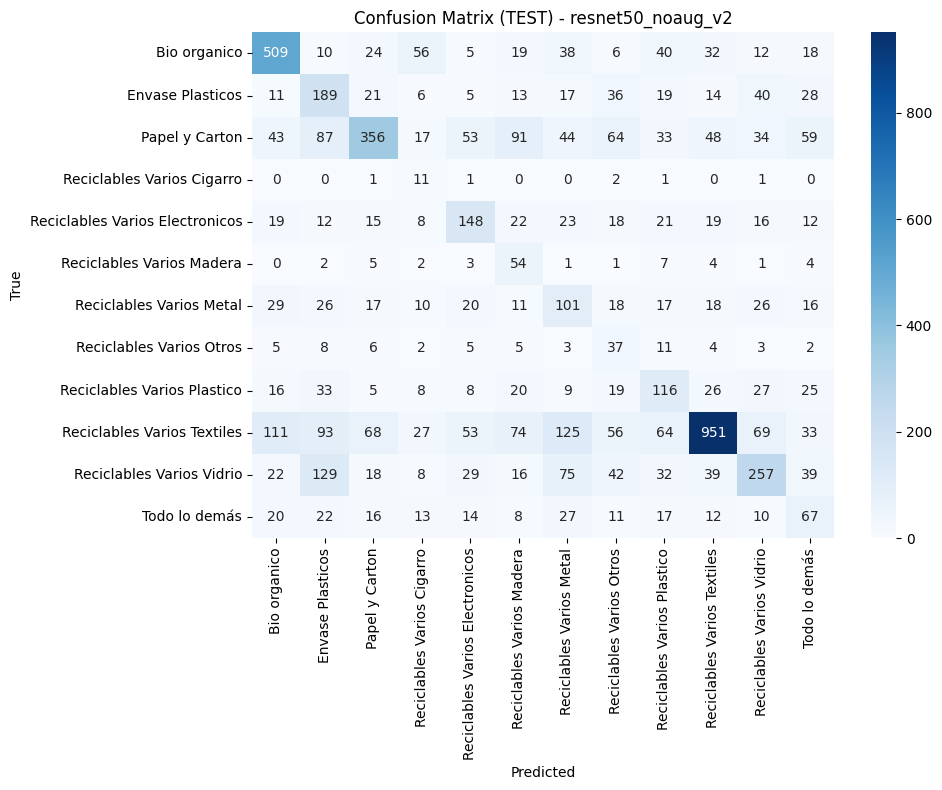

Confusion matrix saved to: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/resnet50_noaug_v2_TEST_confusion_matrix.png
Final model saved to: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/resnet50_noaug_v2_final.keras
Classification report saved to: /content/drive/MyDrive/Colab Notebooks/ComputerVision/experiments/resnet50_noaug_v2/resnet50_noaug_v2_TEST_classification_report.txt


In [11]:
# ------------------------------------------
# Evaluation – Load best model, report metrics on TEST set, save final
# ------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use Phase 2 best if it exists, otherwise Phase 1 best
if os.path.exists(phase2_ckpt_path):
    best_model_path = phase2_ckpt_path
elif os.path.exists(phase1_ckpt_path):
    best_model_path = phase1_ckpt_path
else:
    raise FileNotFoundError("No checkpoint found for this experiment.")

print("Loading best model from:", best_model_path)
best_model = tf.keras.models.load_model(best_model_path)

# 1) Optional: validation performance
val_loss, val_acc = best_model.evaluate(val_gen, verbose=1)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

# 2) MAIN: Test performance
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
print(f"TEST loss: {test_loss:.4f}")
print(f"TEST accuracy: {test_acc:.4f}")

# 3) Detailed classification report on TEST
y_true = test_gen.classes
y_pred_probs = best_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = [index_to_class[i] for i in range(num_classes)]

print("\nClassification Report (TEST):")
report_str = classification_report(y_true, y_pred, target_names=target_names)
print(report_str)

# 4) Confusion matrix (TEST)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (TEST) - {EXP_NAME}")
plt.tight_layout()

cm_fig_path = os.path.join(EXP_DIR, f"{EXP_NAME}_TEST_confusion_matrix.png")
plt.savefig(cm_fig_path, dpi=150)
plt.show()
print("Confusion matrix saved to:", cm_fig_path)

# 5) Save final best model to experiment directory
final_model_path = os.path.join(EXP_DIR, f"{EXP_NAME}_final.keras")
best_model.save(final_model_path)
print("Final model saved to:", final_model_path)

# 6) Save classification report
report_path = os.path.join(EXP_DIR, f"{EXP_NAME}_TEST_classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Experiment: {EXP_NAME}\n")
    f.write(f"Validation loss: {val_loss:.4f}\n")
    f.write(f"Validation accuracy: {val_acc:.4f}\n\n")
    f.write(f"TEST loss: {test_loss:.4f}\n")
    f.write(f"TEST accuracy: {test_acc:.4f}\n\n")
    f.write(report_str)

print("Classification report saved to:", report_path)


###Step 11 -  Continuous training curves (Phase 1 + Phase 2)

Generating training curves...
Found histories, plotting now...
 → Adding 1 epochs from Phase 1 (head)
 → Adding 20 epochs from Phase 2 (fine-tuning)
Plotting training & validation curves...


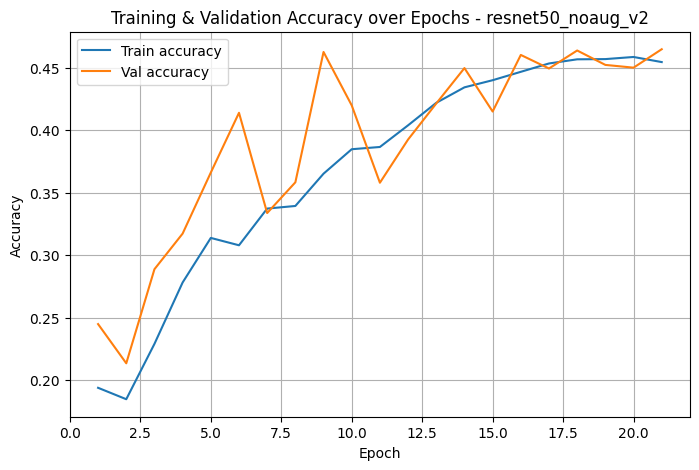

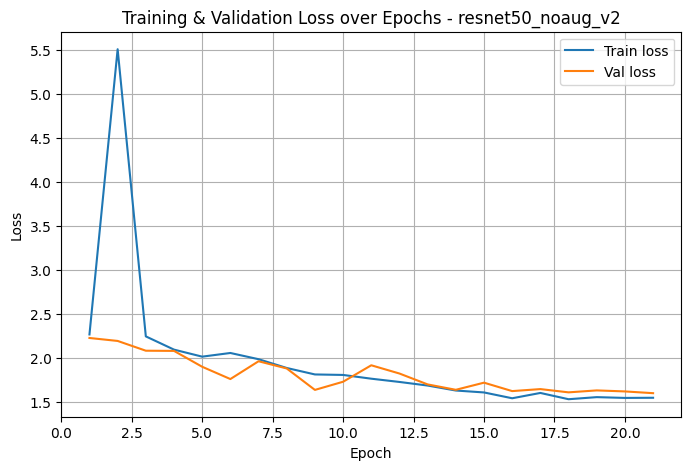

In [18]:
print("Generating training curves...")

# ==========================================================
# Step 11 – Continuous training curves (Phase 1 + Phase 2)
# ==========================================================
import matplotlib.pyplot as plt
import numpy as np

histories = []
phase_names = []

if 'history1' in globals() and history1 is not None:
    histories.append(history1.history)
    phase_names.append("Phase 1 (head)")

if 'history2' in globals() and history2 is not None:
    histories.append(history2.history)
    phase_names.append("Phase 2 (fine-tuning)")

if len(histories) > 0:
    print("Found histories, plotting now...")

    all_epochs = []
    all_acc = []
    all_val_acc = []
    all_loss = []
    all_val_loss = []

    epoch_offset = 0
    for h, name in zip(histories, phase_names):
        n = len(h['loss'])
        print(f" → Adding {n} epochs from {name}")
        epochs = np.arange(epoch_offset + 1, epoch_offset + n + 1)

        all_epochs.extend(epochs)
        all_acc.extend(h.get('accuracy', [np.nan] * n))
        all_val_acc.extend(h.get('val_accuracy', [np.nan] * n))
        all_loss.extend(h.get('loss', [np.nan] * n))
        all_val_loss.extend(h.get('val_loss', [np.nan] * n))

        epoch_offset += n

    print("Plotting training & validation curves...")

    # Accuracy plot
    plt.figure(figsize=(8, 5))
    plt.plot(all_epochs, all_acc, label='Train accuracy')
    plt.plot(all_epochs, all_val_acc, label='Val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training & Validation Accuracy over Epochs - {EXP_NAME}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(all_epochs, all_loss, label='Train loss')
    plt.plot(all_epochs, all_val_loss, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training & Validation Loss over Epochs - {EXP_NAME}')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No histories found (history1/history2). Skipping training curves.")


###Step 12 - Visualize correct vs incorrect test predictions

[resnet50_noaug_v2] Recomputed TEST accuracy (check): 0.4731
Correctly classified test images   : 2796
Incorrectly classified test images : 3114


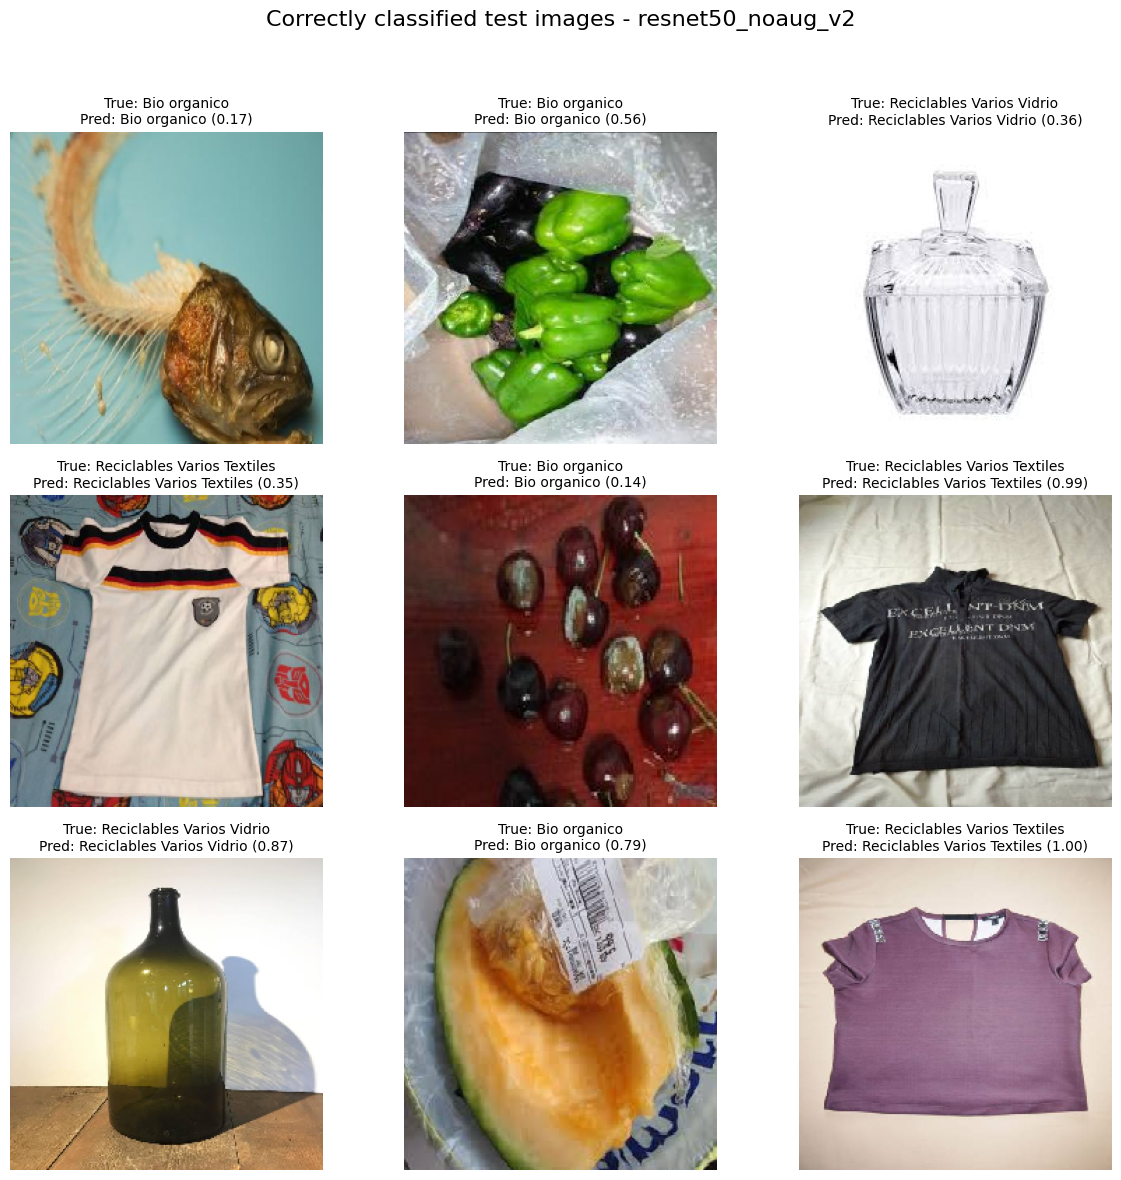

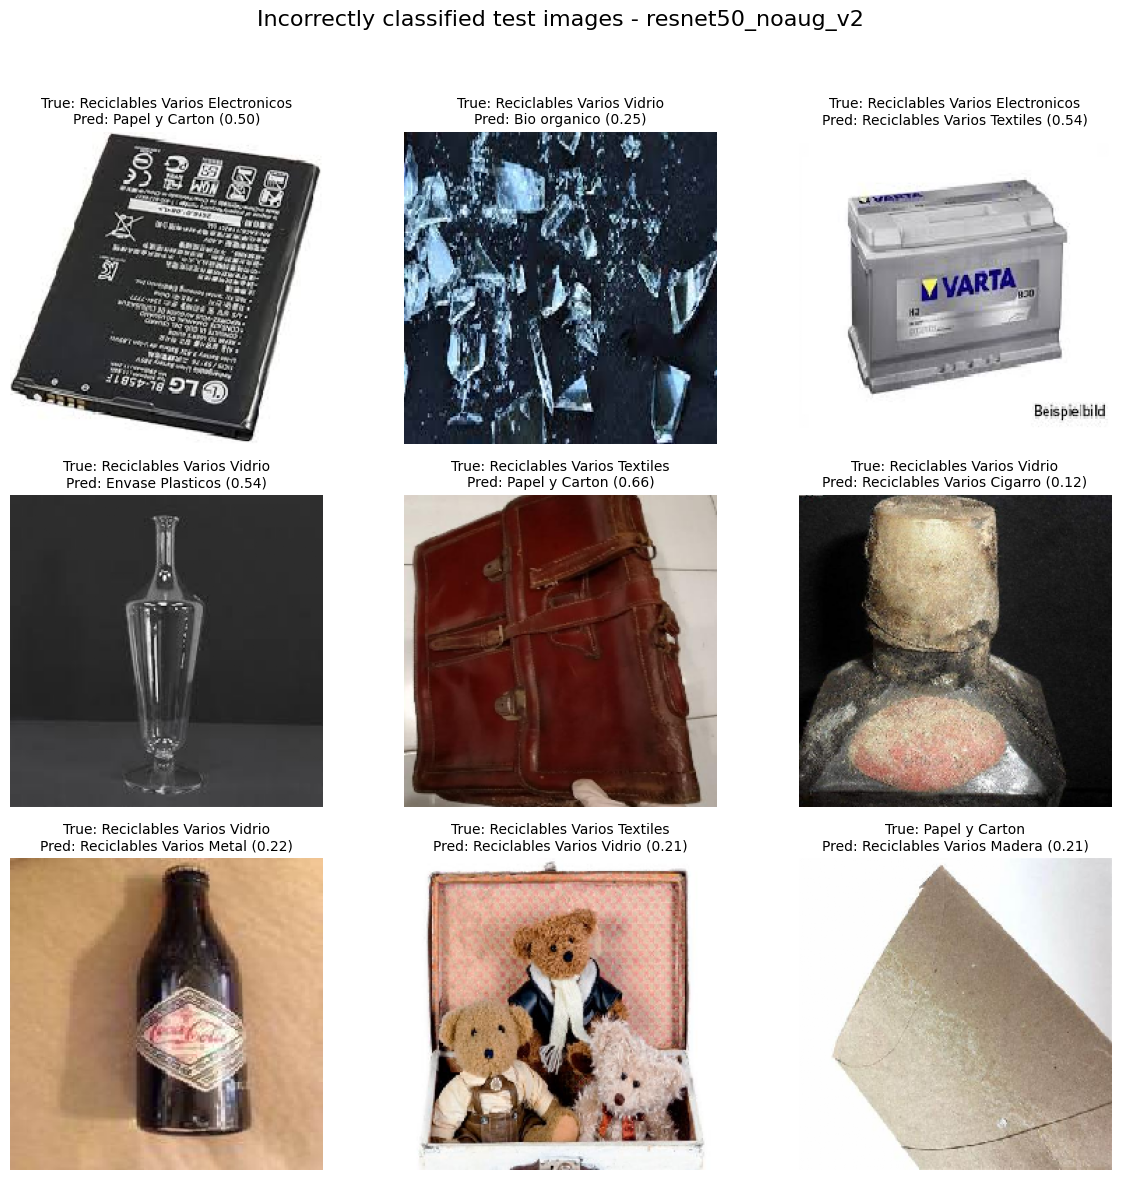

In [15]:
# ==========================================================
# Step 12 – Visualize correct vs incorrect test predictions
# ==========================================================
from tensorflow.keras.preprocessing import image

# Get filepaths from the test generator
filepaths = np.array(test_gen.filepaths)

# Sanity check: basic test accuracy (should match TEST accuracy)
y_prob = y_pred_probs
test_accuracy_recomputed = np.mean(y_pred == y_true)
print(f"[{EXP_NAME}] Recomputed TEST accuracy (check): {test_accuracy_recomputed:.4f}")

# 1) Find correct & incorrect indices
correct_idx = np.where(y_pred == y_true)[0]
incorrect_idx = np.where(y_pred != y_true)[0]

print(f"Correctly classified test images   : {len(correct_idx)}")
print(f"Incorrectly classified test images : {len(incorrect_idx)}")

# 2) Helper function to show a grid of images
def show_examples(indices, n=9, title="Examples", index_to_class=None):
    """
    indices: array of indices in the test set
    n: number of images to display
    index_to_class: dict int -> class name
    """
    if len(indices) == 0:
        print(f"No examples to show for: {title}")
        return

    n = min(n, len(indices))
    chosen = np.random.choice(indices, size=n, replace=False)

    cols = 3
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 4, rows * 4))
    plt.suptitle(title, fontsize=16)

    for i, idx in enumerate(chosen, start=1):
        img_path = filepaths[idx]
        true_label_idx = y_true[idx]
        pred_label_idx = y_pred[idx]
        probs = y_prob[idx]
        pred_conf = probs[pred_label_idx]

        true_label = index_to_class.get(true_label_idx, str(true_label_idx)) if index_to_class else str(true_label_idx)
        pred_label = index_to_class.get(pred_label_idx, str(pred_label_idx)) if index_to_class else str(pred_label_idx)

        img = image.load_img(img_path, target_size=(224, 224))
        img_arr = image.img_to_array(img) / 255.0

        plt.subplot(rows, cols, i)
        plt.imshow(img_arr)
        plt.axis('off')
        plt.title(
            f"True: {true_label}\nPred: {pred_label} ({pred_conf:.2f})",
            fontsize=10
        )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 3) Show some CORRECT predictions
show_examples(
    correct_idx,
    n=9,
    title=f"Correctly classified test images - {EXP_NAME}",
    index_to_class=index_to_class
)

# 4) Show some INCORRECT predictions
show_examples(
    incorrect_idx,
    n=9,
    title=f"Incorrectly classified test images - {EXP_NAME}",
    index_to_class=index_to_class)

### Predictor

In [16]:
# ==========================================================
# Step 13 – Helper for predicting on NEW images
# ==========================================================
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # safety for weird images

import matplotlib.pyplot as plt

def preprocess_single_image(image_path, target_size=IMG_SIZE):
    """
    Loads and preprocesses a single image for prediction.
    - Resizes to target_size
    - Converts to float32
    - Rescales to [0, 1]
    """
    img = load_img(image_path, target_size=target_size)
    arr = img_to_array(img).astype("float32") / 255.0
    return arr

def load_best_experiment_model():
    """
    Loads the best model available for THIS experiment:
    1. Phase 2 (fine-tuned) model, if exists
    2. Otherwise Phase 1 model

    Uses the same checkpoint paths as the training code:
    - phase2_ckpt_path
    - phase1_ckpt_path
    """
    if os.path.exists(phase2_ckpt_path):
        print(f"[{EXP_NAME}] Loading best Phase 2 model for predictions...")
        return tf.keras.models.load_model(phase2_ckpt_path)

    if os.path.exists(phase1_ckpt_path):
        print(f"[{EXP_NAME}] Loading best Phase 1 model for predictions...")
        return tf.keras.models.load_model(phase1_ckpt_path)

    raise FileNotFoundError(
        f"No trained model found for experiment '{EXP_NAME}'. "
        "Train Phase 1 or Phase 2 first."
    )

def predict_image(image_path, model=None, top_k=3, save_result=False):
    """
    Predicts top-K classes for a given image for this NO-AUG experiment.

    Parameters
    ----------
    image_path : str
        Path to the image you want to classify.
    model : tf.keras.Model or None
        If None, will auto-load the best model for this experiment.
    top_k : int
        Number of top predictions to show.
    save_result : bool
        If True, saves a text file with prediction results into EXP_DIR.
    """
    # Auto-load model if needed
    if model is None:
        model = load_best_experiment_model()

    # Preprocess
    arr = preprocess_single_image(image_path)
    arr_batch = np.expand_dims(arr, axis=0)  # (1, H, W, 3)

    # Predict
    preds = model.predict(arr_batch)[0]  # shape: (num_classes,)
    top_indices = np.argsort(preds)[::-1][:top_k]
    top_probs = preds[top_indices]
    top_labels = [index_to_class[i] for i in top_indices]

    # Print predictions
    print(f"\n[{EXP_NAME}] Predictions for: {image_path}")
    for lbl, prob in zip(top_labels, top_probs):
        print(f"  {lbl}: {prob:.4f}")

    # Show image with Top-1 class title
    plt.figure(figsize=(4, 4))
    plt.imshow(arr)
    plt.axis('off')
    plt.title(f"Top-1: {top_labels[0]} ({top_probs[0]:.2f})")
    plt.show()

    # Optionally save prediction results
    if save_result:
        pred_path = os.path.join(EXP_DIR, f"{EXP_NAME}_prediction.txt")
        with open(pred_path, "w") as f:
            f.write(f"Experiment: {EXP_NAME}\n")
            f.write(f"Image: {image_path}\n\n")
            for lbl, prob in zip(top_labels, top_probs):
                f.write(f"{lbl}: {prob:.4f}\n")

        print(f"Prediction saved to: {pred_path}")


[resnet50_noaug_v2] Loading best Phase 2 model for predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

[resnet50_noaug_v2] Predictions for: /content/drive/MyDrive/Colab Notebooks/ComputerVision/new_test_images/test_image_2.jpeg
  Reciclables Varios Plastico: 0.2135
  Reciclables Varios Madera: 0.1520
  Papel y Carton: 0.0972


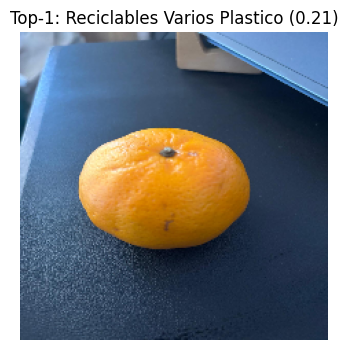

In [17]:
# Example usage (AFTER training):
predict_image('/content/drive/MyDrive/Colab Notebooks/ComputerVision/new_test_images/test_image_2.jpeg')